# PART III : Predicting the language a surname comes from ( BATCHING )

Previously, we train RNN by only inputing 1 sequence at a time. However, when we want to train the input data in batches a problem occurs because the length of the sequences are not equal so we cannot put the batch into a tensor.

As a solution torch has a function called torch.nn.utils.rnn.pad_sequence which takes a list of tensors as inout and it will pad all of the sequence to the same length. Another problem is that calculating these can be computationally expensive since the sentence are all padded to the maximum length.

So another function called torch.nn.utils.rnn.pack_padded_sequence is introduced. This function will pack the first sequences of each padded sequence together, and the second to gether and the third together, so forth. It will also output the batch size of each set of sequence so that the calculations can be more efficient.

I adapted most of the code from here. : 
https://github.com/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/8_RNN_LSTM_Model/BatchingSeqModels.ipynb

I just changes our original input to be compatible with their implementation.

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from IPython.display import clear_output

import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from get_free_gpu import get_free_gpu

device = get_free_gpu()

def findFiles(path):
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"

n_letters = len(all_letters)

In [4]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [5]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../../data/RNN/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

## Create a list containing all names and another list containing all the corresponding languages.

In [4]:
all_cats = list(category_lines.keys())
all_names = []
all_targets = []

for i in all_cats:
    for name in category_lines[i]:
        all_names.append(name)
    all_targets.append([i] * len(category_lines[i]))

fin_targets = []    
for j in range(len(all_targets)):
    for k in all_targets[j]:
        fin_targets.append(k)
    
print(len(all_names))
print(len(fin_targets))

20074
20074


## Split the data into train and test set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(all_names, fin_targets, test_size = 0.2, random_state = 123, stratify = fin_targets)

In [6]:
#count
print("The number of observations in the training data: ", len(X_train))
print("The number of observations in the test data: ", len(X_test))

The number of observations in the training data:  16059
The number of observations in the test data:  4015


In [7]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters) #Create a zeros tensor
    #iterate through all the characters in the name
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1 #Assign a value for each pos value
    return rep

In [9]:
#function to create vec representation of the language
def lang_rep(lang):
    return torch.tensor([all_categories.index(lang)], dtype = torch.long)

In [10]:
# Check that their one-hot encoding function works
name_rep("Fabby")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [11]:
# Check that their language to class number function works
lang_rep("Korean")

tensor([11])

## RNN Architecture

In [12]:
#create simple rnn network 
class RNN_net(nn.Module):
    #Create a constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size 
        self.rnn_cell = nn.RNN(input_size, hidden_size) # Applies a multi-layer Elman RNN with tanh or ReLU non-linearity to an input sequence.
        self.h20 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    #create a forward pass function
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_.to(device), hidden)
        output = self.h20(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size = 1):
        #function to init the hidden layers
        return torch.zeros(1, batch_size, self.hidden_size).to(device)

## Inference Function

In [13]:
#function to run inference
def infer(net, name, device = device):
    name_ohe = name_rep(name).to(device)

    #get the output
    output, hidden = net(name_ohe)

    if type(hidden) is tuple: #for lSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)

    return output

In [14]:
#create hidden layers
n_hidden = 128 #hidden layers count

#initialize the network
net = RNN_net(input_size=n_letters, hidden_size=n_hidden, output_size=n_categories).to(device)

In [15]:
#check for inference
infer(net, "Fabby", device)

tensor([[-3.0165, -2.9141, -2.9239, -2.9212, -2.9115, -2.9406, -2.9432, -2.8423,
         -2.7608, -3.0085, -2.8042, -2.7888, -2.7548, -2.9034, -2.8303, -3.0572,
         -2.7881, -2.9897]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)

## Function to randomly load npoints samples at a time

In [16]:
def dataloader(npoints, X_, y_):
    """Function to load the data"""
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #subset the data
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    
    return to_ret

In [17]:
dataloader(2, X_train, y_train)

[('Gou',
  'Chinese',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]]]),
  tensor([1])),
 ('Holman',
  'English',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.,

## Evaluation Function

In [18]:
#create an evaluation function 

def eval(net, n_points, topk, X_, y_, device = device):
    "Evaluation function"

    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0

    #iterate
    for name, language, name_ohe, lang_rep in data_:
    
        name_ohe = name_ohe.to(device)
        lang_rep = lang_rep.to(device)
        
        #get the output
        output = infer(net, name, device)
        val, indices = output.topk(topk) #get the top k values
        indices = indices.to(device) #convert to devices
        
        if lang_rep in indices:
            correct += 1

    accuracy = correct/n_points
    return accuracy

In [19]:
eval(net, 1000, 1, X_test, y_test)

0.014

## Function for making a one hot encoder of a batch of names

In [20]:
#create a batched name rep

def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

In [21]:
#function to print the output
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [22]:
#example of batching

out_ = batched_name_rep(['Shyam', 'Ram'], 5)
print_char(out_)

S
R
h
a
y
m
a
<pad>
m
<pad>


## Get the language of all the names in a batch

In [23]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = all_categories.index(lang)
    return rep

## Function for downloading the sequences in batches with torch.nn.utils.rnn.pack_padded_sequence

In [24]:
#create dataloader
def batched_dataloader(npoints, X_, y_, verbose=False, device = device):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [25]:
batched_dataloader(2, X_train, y_train, True)

torch.Size([11, 2, 57]) torch.Size([18, 57])
--
['Mozharovsky', 'Yarwood']
M
Y
o
a
z
r
h
w
a
o
r
o
o
d
v
<pad>
s
<pad>
k
<pad>
y
<pad>
--
M
Y
o
a
z
r
h
w
a
o
r
o
o
d
v
s
k
y
Lang Rep tensor([14,  4], device='cuda:1')
Batch sizes tensor([2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1])


(PackedSequence(data=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:1'), batch_sizes=tensor([2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]), sorted_indices=tensor([0, 1], device='cuda:1'), unsorted_indices=tensor([0, 1], device='cuda:1')),
 tensor([14,  4], device='cuda:1'))

## Normal Train Function

In [26]:
#basic train function
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        name_ohe = name_ohe.to(device)
        lang_rep = lang_rep.to(device)
        
        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

## Define parameters for batch training

In [28]:
net = RNN_net(n_letters, n_hidden, n_categories).to(device)
criterion = nn.NLLLoss().to(device)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Batch Train Function

In [29]:
def train_batch(net, opt, criterion, n_points, device = device):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)
    batch_input = batch_input.to(device)
    batch_groundtruth = batch_groundtruth.to(device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

## TRAIN !!!

In [30]:
# Normal Training
# %%time 
# #time for normal training
# train(net, opt, criterion, 256)

CPU times: user 2.4 s, sys: 81.2 ms, total: 2.48 s
Wall time: 2.48 s


tensor(2.8295, device='cuda:1', grad_fn=<DivBackward0>)

In [31]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = device):
    net = net.to(device)
    criterion = nn.NLLLoss().to(device)
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1 Accuracy:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2 Accuracy:', eval(net, len(X_test), 2, X_test, y_test, device))

Iteration 2999 Loss 0.45592594146728516


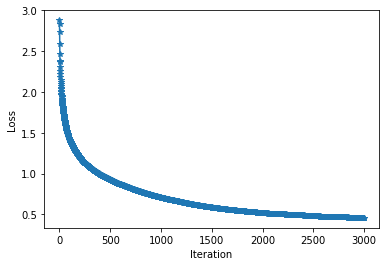




Top-1 Accuracy: 0.7778331257783313 Top-2 Accuracy: 0.8727272727272727
CPU times: user 6min 32s, sys: 2.84 s, total: 6min 35s
Wall time: 3min 30s


In [32]:
%%time

#training RNN using batch technique
net = RNN_net(n_letters, 128, n_categories)
train_setup(net, lr=0.15, n_batches=3000, batch_size = 512, display_freq=500)

# RESULTS

In this part, we train RNN with 3000 batches of sequence, each with batch size 512. And it only takes 6.5 mins. Compared to normal training which would have taken more than 4 hours.

This implementation is clearly more efficient and we can benefit from the GPU ( the results printed out as CPU times but as I have changed all the device to GPU it should mean the GPU time.)

We got Top-1 accuracy of 77% and Top-2 accuracy of 87% which is quite good. The loss are also converging well.